# Analisi delle serie temporali

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd
import xarray as xr

import datetime as dtm
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

In [186]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf, pacf
import pmdarima as pm # auto_arima models
from dateutil.relativedelta import relativedelta # for months difference
from statsmodels.tsa.seasonal import seasonal_decompose # seasonal decomposition
from sklearn.linear_model import LinearRegression # linear regression

import statsmodels.api as sm
from sklearn.metrics import r2_score

#### Hadcrut

Vediamo Acf e Pacf per valutare la tipologia di Arima necessario

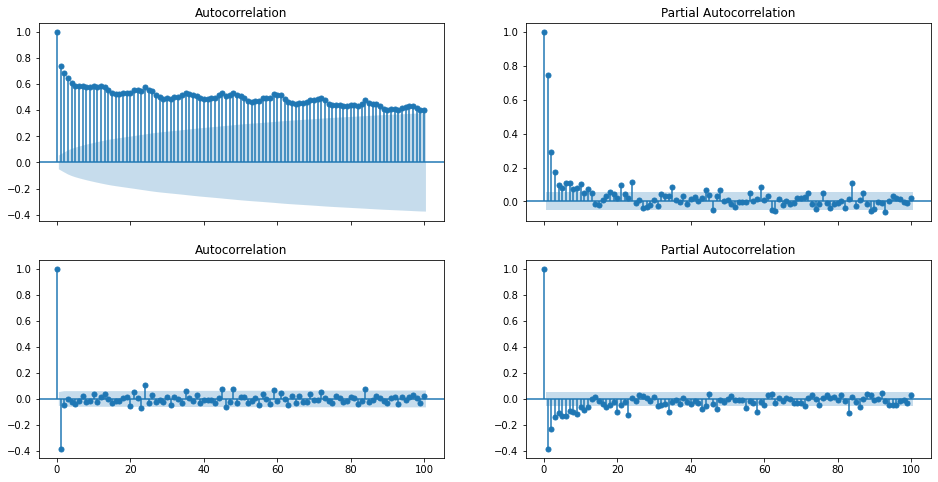

In [18]:
_, axes = plt.subplots(2,2, sharex=True, figsize=(16,8))
plot_acf(hadcrut, lags=100, ax=axes[0][0])
plot_acf(hadcrut.diff().dropna(), lags=100, ax=axes[1][0])
plot_pacf(hadcrut, lags=100, ax=axes[0][1])
plot_pacf(hadcrut.diff().dropna(), lags=100, ax=axes[1][1])
plt.show()

In [51]:
smodel = pm.auto_arima(hadcrut, start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       start_P=1, start_Q = 1, max_P = 2, max_Q = 2, D = 1, d = 1,
                       m = 12, max_order = None, seasonal = True, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2023.301, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1327.617, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1792.272, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1201.500, Time=0.56 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1427.163, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1111.391, Time=0.88 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1237.227, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1075.206, Time=1.08 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1196.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1380
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -531.603
Date:                            Tue, 08 Jun 2021   AIC                           1075.206
Time:                                    21:50:15   BIC                           1106.528
Sample:                                         0   HQIC                          1086.929
                                           - 1380                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5354      0.020    -26.427      0.000      -0.575      -0.496
ar.L2         -0.3376      0.027    -12.640      0.000      -0.390      -0.285
ar.L3         -0.1665      0.027     -6.130      0.000      -0.220      -0.113
ar.S.L12      -0.7015      0.020    -35.850      0.000      -0.740      -0.663
ar.S.L24      -0.2975      0.021    -14.504      0.000      -0.338      -0.257
sigma2         0.1268      0.004     33.821      0.000       0.119       0.134
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               147.77
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
# set timeline to predict
future = pd.date_range(start='2014-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

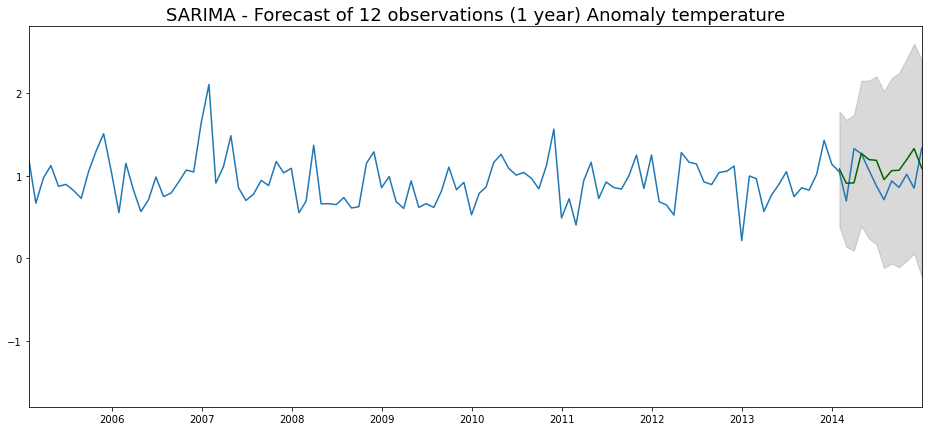

In [53]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(hadcrut.index[-12], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(hadcrut.index, hadcrut.value)

plt.plot(future, fitted_series, color='darkgreen')
plt.fill_between(future, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.xlim(hadcrut.index[-120], future[-1]) 

plt.title("SARIMA - Forecast of 12 observations (1 year) Anomaly temperature", size = 18)
plt.show()

#### Arima mensili

In [54]:
arimas = list()
for month in range(12):
    print(" ------------------------ ")
    print(f"Computing ARIMA month {month}")
    print(" ------------------------ ")
    arima_current = pm.auto_arima(hadcrut_m[month], start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       max_d = 1, P = 0, Q = 0, D = 0,
                       max_order = None, seasonal = False, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)
    arimas.append(arima_current)

 ------------------------ 
Computing ARIMA month 0
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=154.976, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=237.409, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=187.200, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=157.111, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=235.468, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=156.928, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=156.882, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=155.197, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=176.892, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=158.864, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=155.782, Time=0.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.583 seconds
 ------------------------ 
Computing ARIMA month 1
 ------------------------ 
Performin

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=126.177, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104.328, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=157.214, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=106.278, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=106.265, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=105.516, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.267 seconds
 ------------------------ 
Computing ARIMA month 11
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=153.124, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=200.427, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=174.656, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=185.458, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=155.065, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=155.070, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[

#### Prediction

In [83]:
n_periods = 24
fitted = np.array([])
confint = list()
index_of_fc = list()
fitted_series = pd.DataFrame({})
lower_series = pd.DataFrame({})
upper_series = pd.DataFrame({})

for month in range(1):
    fitted_c, confint_c = arimas[month].predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc_c = pd.date_range(hadcrut_m[month].index[-1] + relativedelta(month=1), 
                                  periods=n_periods, freq='M')
    # make series for plotting purpose
    fitted_series_c = pd.Series(fitted_c, index=index_of_fc_c)
    lower_series_c = pd.Series(confint_c[:, 0], index=index_of_fc_c)
    upper_series_c = pd.Series(confint_c[:, 1], index=index_of_fc_c)
    
    fitted = np.concatenate((fitted, fitted_c))
    confint.append(confint_c)
    index_of_fc.append(index_of_fc_c)
    fitted_series = pd.concat([fitted_series, fitted_series_c], axis=0).sort_index()
    lower_series = pd.concat([lower_series, lower_series_c], axis=0).sort_index()
    upper_series = pd.concat([upper_series, upper_series_c], axis=0).sort_index()

In [84]:
fitted_series

,0
2014-01-31,0.946402
2014-02-28,0.981586
2014-03-31,0.988378
2014-04-30,1.001217
2014-05-31,1.012769
2014-06-30,1.024594
2014-07-31,1.036361
2014-08-31,1.048141
2014-09-30,1.059918
2014-10-31,1.071695


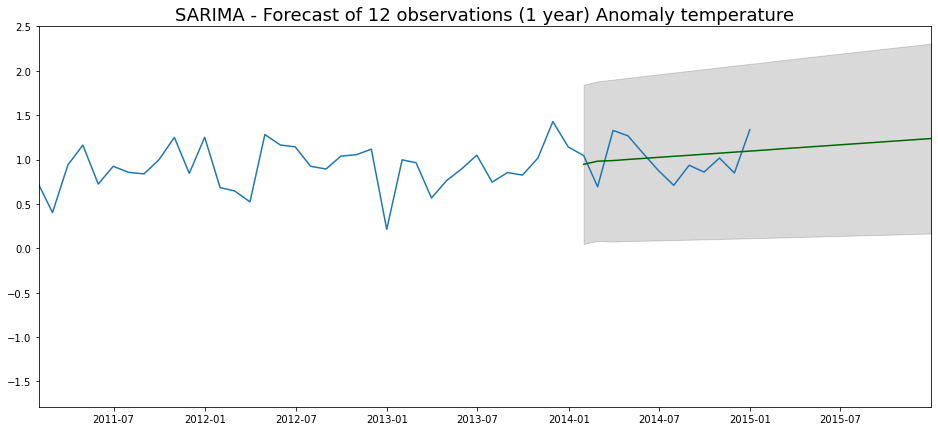

In [85]:
# set timeline to predict
future = pd.date_range(start='2014-01-01 01:00:00', end='2016-01-01 00:00:00', freq = 'M')

plt.figure(figsize=(16, 7))

plt.plot(hadcrut.index, hadcrut.value)

plt.plot(fitted_series.index, fitted_series.values, color='darkgreen')
plt.fill_between(fitted_series.index, 
                 lower_series[0].values, 
                 upper_series[0].values, 
                 color='k', alpha=.15)
plt.xlim(hadcrut.index[-48], future[-1]) 

plt.title("SARIMA - Forecast of 12 observations (1 year) Anomaly temperature", size = 18)
plt.show()

In [2]:
hadcrut = pd.read_csv('models/hadcrut4_7457_ts.csv')
hadcrut['time'] = pd.to_datetime(hadcrut['time'], format="%Y-%m-%d")
hadcrut =hadcrut.set_index(['time'])

ensamble = pd.read_csv('models/ensamble_ts.csv')
ensamble['time'] = pd.to_datetime(ensamble['time'], format="%Y-%m-%d")
ensamble = ensamble.set_index(['time'])

In [3]:
hadcrut.head()

,value
time,
1850-01-31,-3.407028
1850-02-28,0.436040
1850-03-31,-1.410218
1850-04-30,-1.300772
1850-05-31,-1.002276


In [4]:
ensamble.head()

,value
time,
1850-01-31,-0.457675
1850-02-28,-0.521243
1850-03-31,-0.400848
1850-04-30,-0.372874
1850-05-31,-0.357068


Seleziono il periodo 1901-2014, ovvero il periodo di dati comune tra le due serie storiche più consistente

In [5]:
hadcrut = hadcrut[(hadcrut.index.year >= 1900)]
hadcrut = hadcrut[(hadcrut.index.year <= 2014)]
hadcrut.shape

(1380, 1)

In [6]:
ensamble = ensamble[(ensamble.index.year >= 1900)]
ensamble = ensamble[(ensamble.index.year <= 2014)]
ensamble.shape

(1380, 1)

## Plot versione annuale

In [7]:
hadcrut_y = hadcrut.groupby(hadcrut.index.year).mean()
ensamble_y = ensamble.groupby(ensamble.index.year).mean()

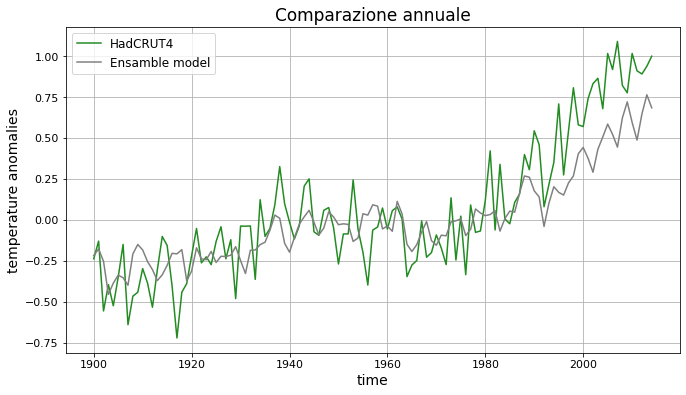

In [8]:
plt.figure(figsize = (11,6))
plt.plot(hadcrut_y.index, hadcrut_y.value, color = "forestgreen", label = "HadCRUT4")
plt.plot(ensamble_y.value, color = "gray", label = "Ensamble model")

plt.title("Comparazione annuale", size = 17)
plt.legend(fontsize = 12)
plt.xlabel("time", size = 14)
plt.ylabel("temperature anomalies", size = 14)
plt.xticks(size = 11)
plt.yticks(size = 11)

plt.grid()

Si può notare anche graficamente che le due serie di anomalie hanno comportamento simile. Verifichiamo la loro indipendenza tramite un ``t-test``

In [9]:
from scipy import stats

In [10]:
t, p_value = stats.ttest_ind(hadcrut_y.value, ensamble_y.value, equal_var = False)
print(f"Annuale - t = {round(t,4)}, p-value = {round(p_value)}")

Annuale - t = 1.2942, p-value = 0


Con un p value decisamente significativo rifiutiamo l'ipotesi nulla di indipendenza tra le due serie.

## Comparazione serie storiche mensili

In [11]:
hadcrut_m = []
for i in range(12):
    hadcrut_m.append(hadcrut[hadcrut.index.month == i+1])

In [12]:
ensamble_m = []
for i in range(12):
    ensamble_m.append(ensamble[ensamble.index.month == i+1])

In [13]:
mese = ['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno', 'Luglio', 
        'Agosto', 'Settembre', 'Ottobre', 'Novembre', 'Dicembre']

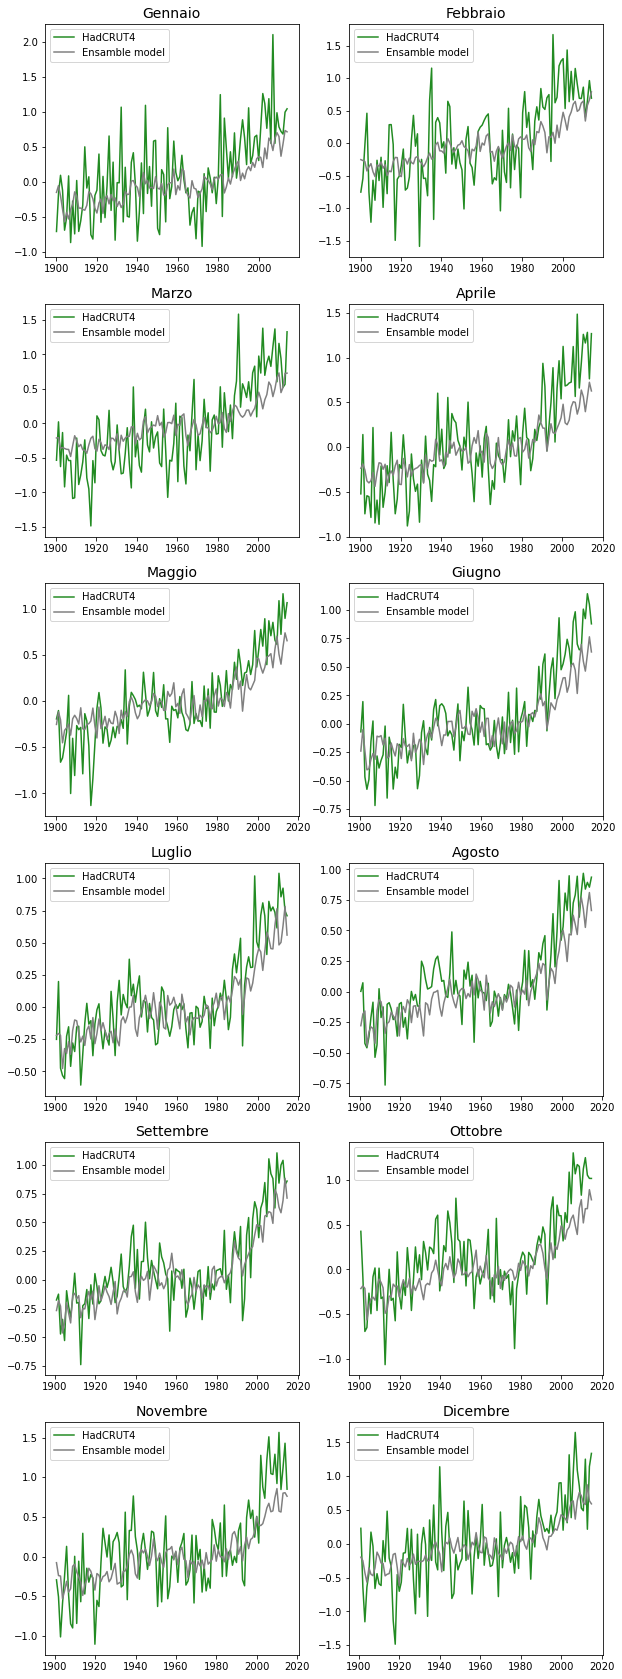

In [14]:
plt.subplots(nrows=6, ncols=2, figsize=(10,30))

for i in range(12):
    plt.subplot(6,2,i+1)
    plt.plot(hadcrut_m[i].index, hadcrut_m[i].value, color = "forestgreen", label = "HadCRUT4")
    plt.plot(ensamble_m[i].value, color = "gray", label = "Ensamble model")
    plt.title(mese[i], fontsize = 14)
    plt.legend(fontsize = 10)

### T-test di indipendenza

In [15]:
for i in range(12):
    t, p_value = stats.ttest_ind(hadcrut_m[i].value, ensamble_m[i].value, equal_var = False)
    print(f"{mese[i]}, t = {round(t,4)}, p-value = {round(p_value,4)}")

Gennaio, t = 2.0822, p-value = 0.0389
Febbraio, t = 1.1483, p-value = 0.2526
Marzo, t = -0.7621, p-value = 0.4471
Aprile, t = 0.9984, p-value = 0.3196
Maggio, t = 0.0671, p-value = 0.9465
Giugno, t = 1.1922, p-value = 0.2347
Luglio, t = 1.32, p-value = 0.1883
Agosto, t = 1.8532, p-value = 0.0653
Settembre, t = 1.523, p-value = 0.1293
Ottobre, t = 2.493, p-value = 0.0135
Novembre, t = 1.3319, p-value = 0.1846
Dicembre, t = 0.8162, p-value = 0.4155


# Arima modeling

Proviamo ad applicare una modellazione Arima alle due serie temporali

## Hadcrut

Vediamo Acf e Pacf per valutare la tipologia di Arima necessario

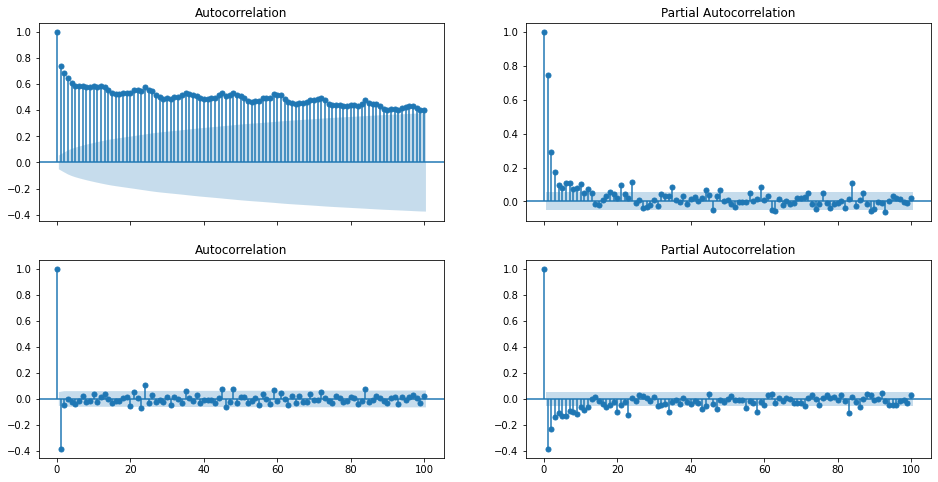

In [18]:
_, axes = plt.subplots(2,2, sharex=True, figsize=(16,8))
plot_acf(hadcrut, lags=100, ax=axes[0][0])
plot_acf(hadcrut.diff().dropna(), lags=100, ax=axes[1][0])
plot_pacf(hadcrut, lags=100, ax=axes[0][1])
plot_pacf(hadcrut.diff().dropna(), lags=100, ax=axes[1][1])
plt.show()

In [172]:
smodel = pm.auto_arima(hadcrut, start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       start_P=1, start_Q = 1, max_P = 2, max_Q = 2, D = 1, d = 1,
                       m = 12, max_order = None, seasonal = True, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2023.301, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1327.617, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1792.272, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1201.500, Time=0.56 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1427.163, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1111.391, Time=0.84 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1237.227, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1075.206, Time=1.07 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1196.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1380
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -531.603
Date:                            Tue, 08 Jun 2021   AIC                           1075.206
Time:                                    22:31:02   BIC                           1106.528
Sample:                                         0   HQIC                          1086.929
                                           - 1380                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5354      0.020    -26.427      0.000      -0.575      -0.496
ar.L2         -0.3376      0.027    -12.640      0.000      -0.390      -0.285
ar.L3         -0.1665      0.027     -6.130      0.000      -0.220      -0.113
ar.S.L12      -0.7015      0.020    -35.850      0.000      -0.740      -0.663
ar.S.L24      -0.2975      0.021    -14.504      0.000      -0.338      -0.257
sigma2         0.1268      0.004     33.821      0.000       0.119       0.134
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               147.77
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Prediction

In [173]:
# set timeline to predict
future = pd.date_range(start='2015-01-01 01:00:00', end='2016-01-01 00:00:00', freq = 'M')

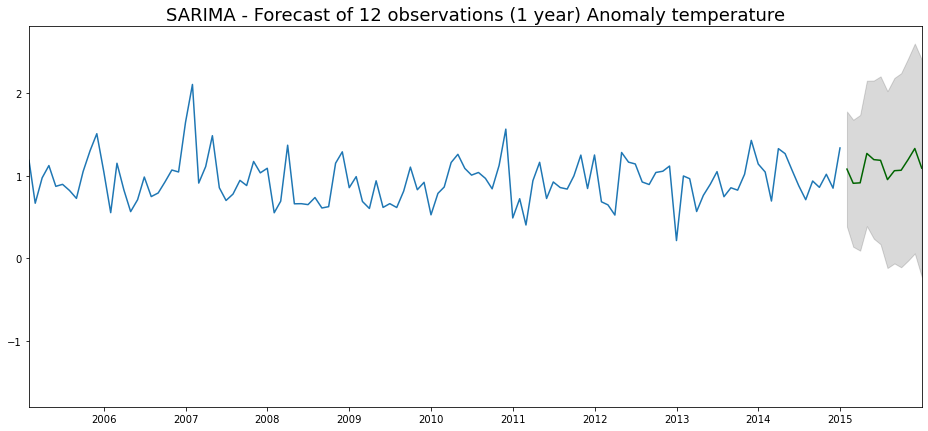

In [174]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(hadcrut.index[-12], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(hadcrut.index, hadcrut.value)

plt.plot(future, fitted_series, color='darkgreen')
plt.fill_between(future, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.xlim(hadcrut.index[-120], future[-1]) 

plt.title("SARIMA - Forecast of 12 observations (1 year) Anomaly temperature", size = 18)
plt.show()

### Arima mensili

In [167]:
arimas = list()
for month in range(12):
    print(" ------------------------ ")
    print(f"Computing ARIMA month {month}")
    print(" ------------------------ ")
    arima_current = pm.auto_arima(hadcrut_m[month], start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       max_d = 1, P = 0, Q = 0, D = 0,
                       max_order = None, seasonal = False, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)
    arimas.append(arima_current)

 ------------------------ 
Computing ARIMA month 0
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=154.976, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=237.409, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=187.200, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=157.111, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=235.468, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=156.928, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=156.882, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=155.197, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=176.892, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=158.864, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=155.782, Time=0.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.626 seconds
 ------------------------ 
Computing ARIMA month 1
 ------------------------ 
Performin

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104.328, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=157.214, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=106.278, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=106.265, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=105.516, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.269 seconds
 ------------------------ 
Computing ARIMA month 11
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=153.124, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=200.427, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=174.656, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=185.458, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=155.065, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=155.070, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=178.336, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[

#### Prediction

In [168]:
# set timeline to predict
future = pd.date_range(start='2015-01-01 01:00:00', end='2016-01-01 00:00:00', freq = 'M')

n_periods = 1
fitted = np.array([])
confint = list()
index_of_fc = list()
fitted_series = pd.DataFrame({})
lower_series = pd.DataFrame({})
upper_series = pd.DataFrame({})

for month in range(12):
    fitted_c, confint_c = arimas[month].predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc_c = pd.date_range(hadcrut_m[month].index[-1] + relativedelta(years=1), 
                                  periods=n_periods, freq='M')
    # make series for plotting purpose
    fitted_series_c = pd.Series(fitted_c, index=index_of_fc_c)
    lower_series_c = pd.Series(confint_c[:, 0], index=index_of_fc_c)
    upper_series_c = pd.Series(confint_c[:, 1], index=index_of_fc_c)
    
    fitted = np.concatenate((fitted, fitted_c))
    confint.append(confint_c)
    index_of_fc.append(index_of_fc_c)
    fitted_series = pd.concat([fitted_series, fitted_series_c], axis=0).sort_index()
    lower_series = pd.concat([lower_series, lower_series_c], axis=0).sort_index()
    upper_series = pd.concat([upper_series, upper_series_c], axis=0).sort_index()

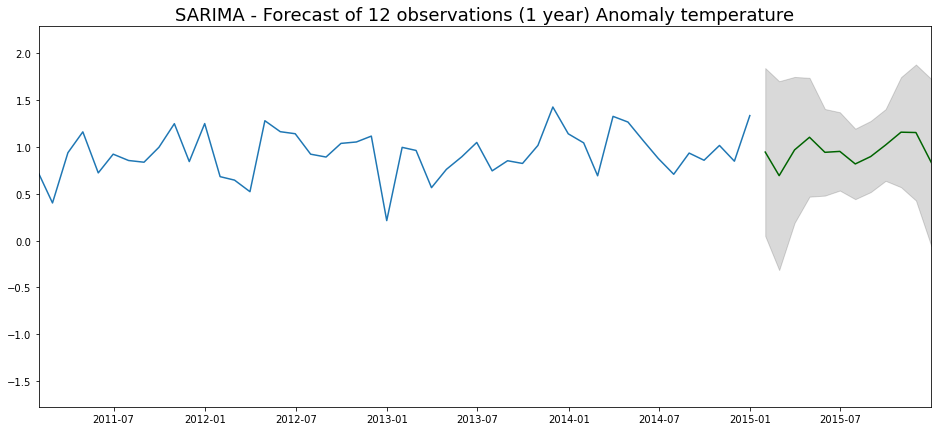

In [169]:
plt.figure(figsize=(16, 7))

plt.plot(hadcrut.index, hadcrut.value)

plt.plot(fitted_series.index, fitted_series.values, color='darkgreen')
plt.fill_between(fitted_series.index, 
                 lower_series[0].values, 
                 upper_series[0].values, 
                 color='k', alpha=.15)
plt.xlim(hadcrut.index[-48], future[-1]) 

plt.title("SARIMA - Forecast of 12 observations (1 year) Anomaly temperature", size = 18)
plt.show()

### Model Ensamble

Vediamo Acf e Pacf per valutare la tipologia di Arima necessario

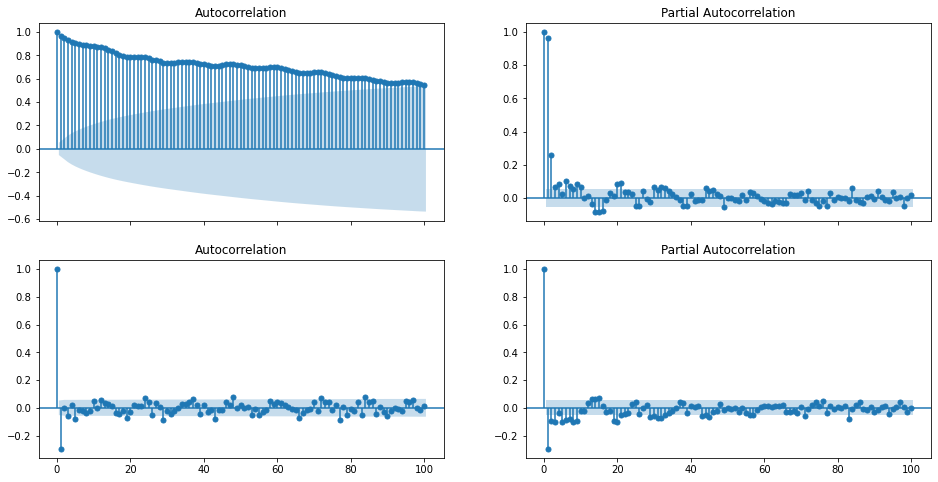

In [87]:
_, axes = plt.subplots(2,2, sharex=True, figsize=(16,8))
plot_acf(ensamble, lags=100, ax=axes[0][0])
plot_acf(ensamble.diff().dropna(), lags=100, ax=axes[1][0])
plot_pacf(ensamble, lags=100, ax=axes[0][1])
plot_pacf(ensamble.diff().dropna(), lags=100, ax=axes[1][1])
plt.show()

In [88]:
smodel = pm.auto_arima(ensamble, start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       start_P=1, start_Q = 1, max_P = 2, max_Q = 2, D = 1, d = 1,
                       m = 12, max_order = None, seasonal = True, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2435.933, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3006.668, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-2596.880, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3150.308, Time=0.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.94 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-2974.710, Time=0.30 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-3180.106, Time=0.94 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3028.834, Time=0.54 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.04 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-3204.088, Time=1.03 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1380
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                1611.391
Date:                             Tue, 08 Jun 2021   AIC                          -3208.783
Time:                                     22:08:15   BIC                          -3172.240
Sample:                                          0   HQIC                         -3195.106
                                            - 1380                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0512      0.136      0.376      0.707      -0.216       0.318
ar.L2         -0.0161      0.064     -0.254      0.800      -0.141       0.108
ar.L3         -0.0623      0.039     -1.587      0.113      -0.139       0.015
ma.L1         -0.4861      0.134     -3.634      0.000      -0.748      -0.224
ar.S.L12      -0.6660      0.024    -27.462      0.000      -0.714      -0.618
ar.S.L24      -0.3298      0.026    -12.544      0.000      -0.381      -0.278
sigma2         0.0055      0.000     27.237      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.85
Prob(Q):                              0.99   Prob(JB):                         0.15
Heteroskedasticity (H):               1.04   Skew:                            -0.06
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
# set timeline to predict
future = pd.date_range(start='2015-01-01 01:00:00', end='2016-01-01 00:00:00', freq = 'M')

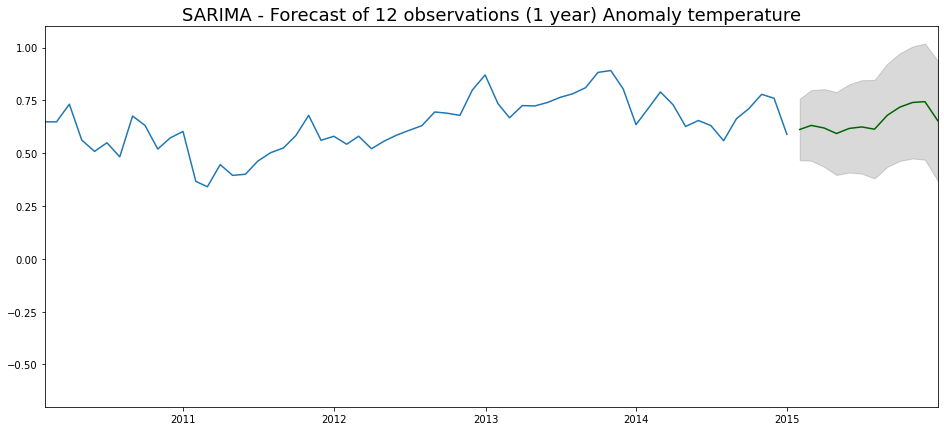

In [101]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(ensamble.index[-12], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(ensamble.index, ensamble.value)

plt.plot(future, fitted_series, color='darkgreen')
plt.fill_between(future, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.xlim(hadcrut.index[-60], future[-1]) 

plt.title("SARIMA - Forecast of 12 observations (1 year) Anomaly temperature", size = 18)
plt.show()

#### Arima mensili

In [102]:
arimas = list()
for month in range(12):
    print(" ------------------------ ")
    print(f"Computing ARIMA month {month}")
    print(" ------------------------ ")
    arima_current = pm.auto_arima(ensamble_m[month], start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       max_d = 1, P = 0, Q = 0, D = 0,
                       max_order = None, seasonal = False, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)
    arimas.append(arima_current)

 ------------------------ 
Computing ARIMA month 0
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-153.254, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-132.769, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-139.273, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-146.906, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-134.397, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-151.887, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-152.922, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-140.769, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-149.313, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-150.680, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.803 seconds
 ------------------------ 
Computing ARIMA month 1
 ------------------------ 
Per

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-197.689, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-178.091, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-182.428, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-194.326, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-179.387, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-199.458, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-194.024, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-197.458, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-209.230, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-211.040, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-200.818, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-204.413, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-206.990, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

#### Prediction

In [162]:
# set timeline to predict
future = pd.date_range(start='2015-01-01 01:00:00', end='2017-01-01 00:00:00', freq = 'M')

n_periods = 1
fitted = np.array([])
confint = list()
index_of_fc = list()
fitted_series = pd.DataFrame({})
lower_series = pd.DataFrame({})
upper_series = pd.DataFrame({})

for month in range(12):
    fitted_c, confint_c = arimas[month].predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc_c = pd.date_range(ensamble_m[month].index[-1] + relativedelta(years=1), 
                                  periods=n_periods, freq='M')
    # make series for plotting purpose
    fitted_series_c = pd.Series(fitted_c, index=index_of_fc_c)
    lower_series_c = pd.Series(confint_c[:, 0], index=index_of_fc_c)
    upper_series_c = pd.Series(confint_c[:, 1], index=index_of_fc_c)
    
    fitted = np.concatenate((fitted, fitted_c))
    confint.append(confint_c)
    index_of_fc.append(index_of_fc_c)
    fitted_series = pd.concat([fitted_series, fitted_series_c], axis=0).sort_index()
    lower_series = pd.concat([lower_series, lower_series_c], axis=0).sort_index()
    upper_series = pd.concat([upper_series, upper_series_c], axis=0).sort_index()

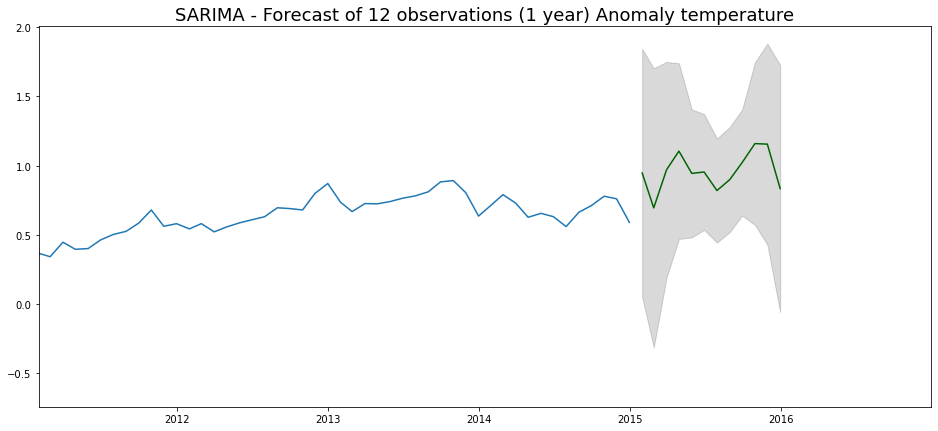

In [164]:
plt.figure(figsize=(16, 7))

plt.plot(ensamble.index, ensamble.value)

plt.plot(fitted_series.index, fitted_series.values, color='darkgreen')
plt.fill_between(fitted_series.index, 
                 lower_series[0].values, 
                 upper_series[0].values, 
                 color='k', alpha=.15)
plt.xlim(hadcrut.index[-48], future[-1]) 

plt.title("SARIMA - Forecast of 12 observations (1 year) Anomaly temperature", size = 18)
plt.show()

# Trend Analysis

## Hadcrut

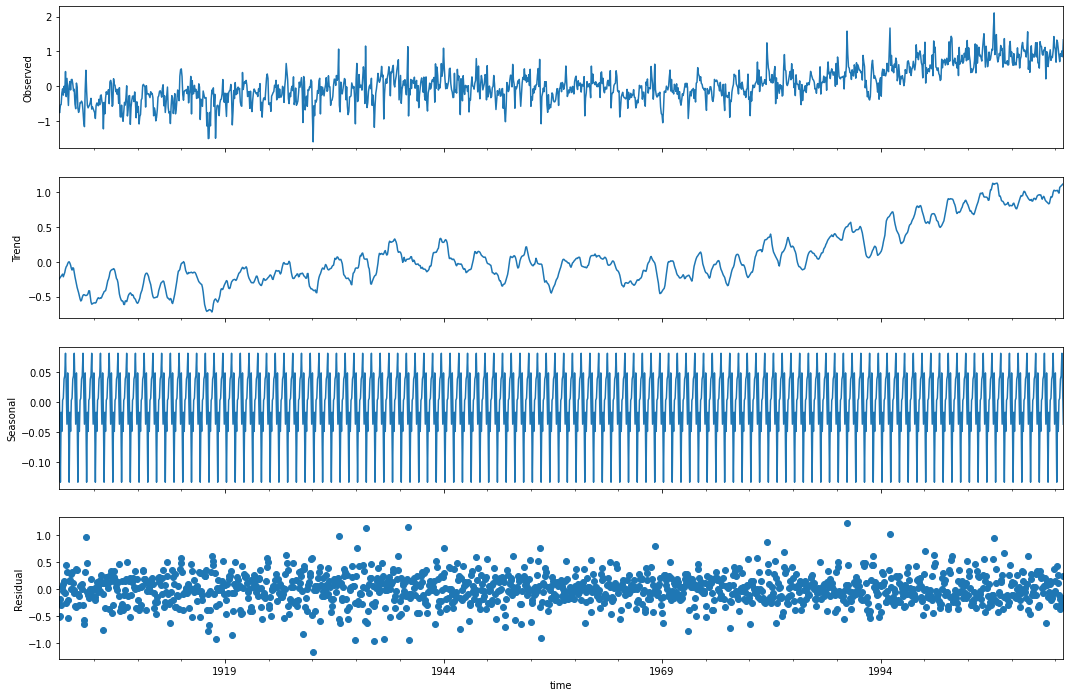

In [178]:
result_add = seasonal_decompose(hadcrut.value, model='additive', extrapolate_trend='freq',
                               period=12)

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(18,12))
result_add.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False, style='o')
axes[3].set_ylabel('Residual')
plt.show()

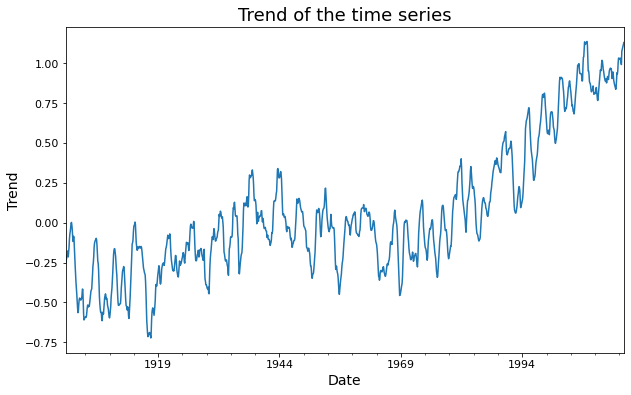

In [180]:
result_add = seasonal_decompose(hadcrut.value, model='additive', extrapolate_trend='freq',
                               period=12)
trend = result_add.trend

fig, axes = plt.subplots(figsize=(10,6))
plt.title('Trend of the time series', size = 18)
trend.plot(ax=axes, legend=False)
axes.set_ylabel('Trend')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Trend", fontsize=14)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

Effettuo una semplice regressione lineare

In [183]:
trend_val = trend.values
time_line = np.linspace(0, trend_val.shape[0], trend_val.shape[0])
regr = LinearRegression()
regr.fit(time_line.reshape(-1,1), trend_val.reshape(-1,1))

LinearRegression()

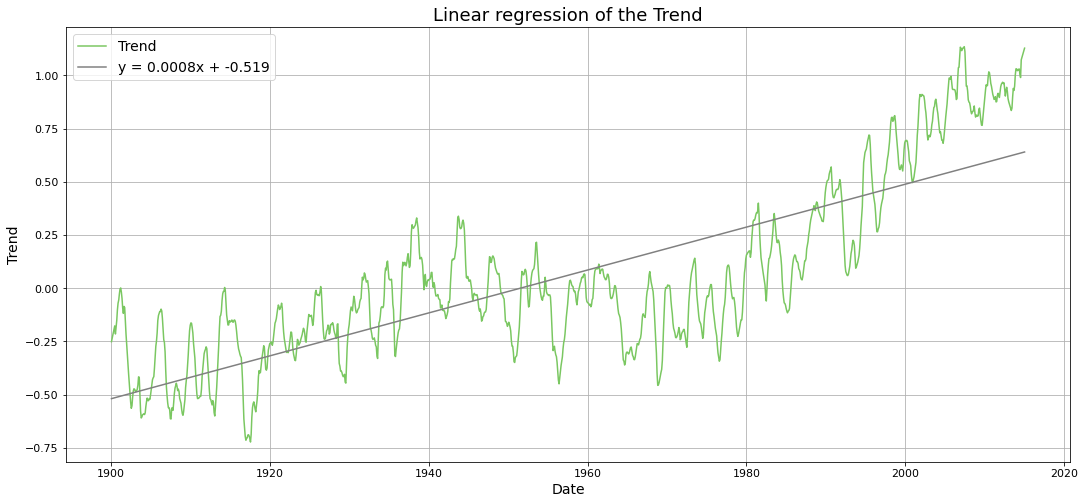

In [184]:
line_regr = regr.predict(time_line.reshape(-1,1))

plt.figure(figsize=(18,8))
plt.plot(trend.index, trend.values, color = '#7AC761', label = "Trend")
plt.plot(trend.index, regr.intercept_[0] + time_line*regr.coef_[0][0] , color = "gray", 
         label = f"y = {round(regr.coef_[0][0],4)}x + {round(regr.intercept_[0],4)}")

plt.xticks(size = 11)
plt.yticks(size = 11)
plt.xlabel("Date", size = 14)
plt.ylabel("Trend", size = 14)
plt.title("Linear regression of the Trend", size = 18)
plt.grid(True)
plt.legend(fontsize=14)

### Regressione polinomiale

In [187]:
def regression_polynomial(x, y, i):
    # Add all variables as power of x to the regression model
    data = pd.DataFrame({'x':x, 'y':y})
    variables = ['x']
    for j in range(2, i+1):
        variables.append(f'x{j}')
        data[f'x{j}'] = data['x'] ** j
    
    X = data[variables]
    Y = data['y']

    X = sm.add_constant(X) # adding a constant
    model = sm.OLS(Y, X).fit()
    
    return model

In [203]:
model_2 = regression_polynomial(time_line, trend, 2)
model_3 = regression_polynomial(time_line, trend, 3)
model_4 = regression_polynomial(time_line, trend, 4)

In [216]:
# Plot the result by building an expression for the fitting function
def plot_regression(model, time_line, value, i):
    x = np.linspace(time_line.min(), time_line.max(), 100)
    label = f"{round(model.params['const'],3)} + {round(model.params['x'],3)}*x "
    yhat = model.params['const'] + model.params['x'] * x
    for j in range(2, i+1):
        label = label + f"+ {round(model.params[f'x{j}'],3)}*x^{j} "
        yhat += model.params[f'x{j}'] * (x**j)
    
    #some confidence interval
    #ci = 1.96 * np.std(yhat)/np.mean(yhat)
    #fig, ax = plt.subplots()
    plt.plot(x, yhat, lw=2, c='forestgreen', label = label)
    #plt.fill_between(x, (yhat-ci), (yhat+ci), color='forestgreen', alpha=.5)

    plt.plot(time_line, value, color='gray')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(-0.2, 0.6, 1.2, -0.7), fontsize=11)

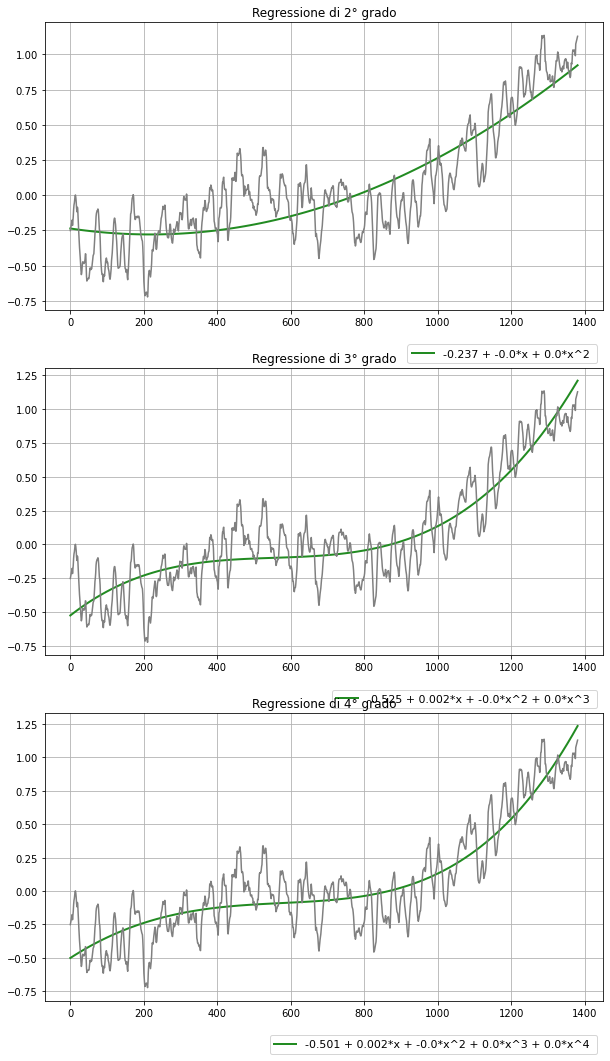

In [217]:
plt.subplots(3,1, figsize = (10,18))
for z,model in enumerate([model_2,model_3,model_4]):
    plt.subplot(3,1,z+1)
    plot_regression(model, time_line, trend, z+2)
    plt.title(f"Regressione di {z+2}° grado")

In [218]:
print(f"r^2 of model_2 is: {round(model_2.rsquared,4)}")
print(f"r^2 of model_3 is: {round(model_3.rsquared,4)}")
print(f"r^2 of model_4 is: {round(model_4.rsquared,4)}")

r^2 of model_2 is: 0.7471
r^2 of model_3 is: 0.8167
r^2 of model_4 is: 0.8171


## Ensamble

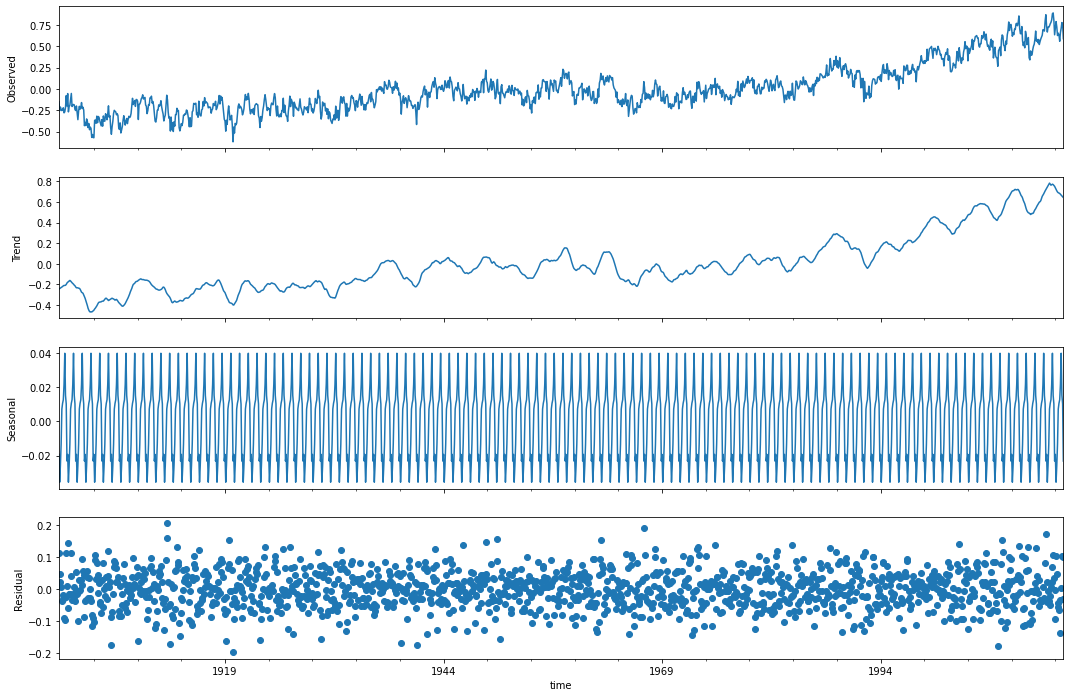

In [219]:
result_add = seasonal_decompose(ensamble.value, model='additive', extrapolate_trend='freq',
                               period=12)

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(18,12))
result_add.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False, style='o')
axes[3].set_ylabel('Residual')
plt.show()

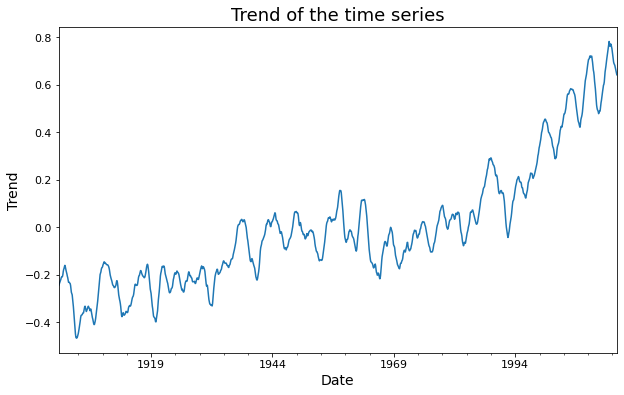

In [220]:
result_add = seasonal_decompose(ensamble.value, model='additive', extrapolate_trend='freq',
                               period=12)
trend = result_add.trend

fig, axes = plt.subplots(figsize=(10,6))
plt.title('Trend of the time series', size = 18)
trend.plot(ax=axes, legend=False)
axes.set_ylabel('Trend')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Trend", fontsize=14)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

Effettuo una semplice regressione lineare

In [221]:
trend_val = trend.values
time_line = np.linspace(0, trend_val.shape[0], trend_val.shape[0])
regr = LinearRegression()
regr.fit(time_line.reshape(-1,1), trend_val.reshape(-1,1))

LinearRegression()

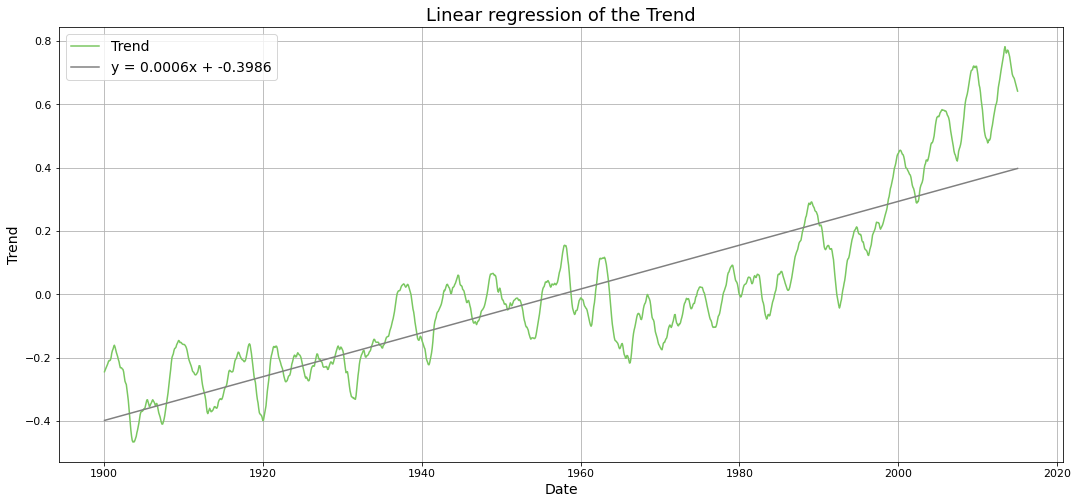

In [222]:
line_regr = regr.predict(time_line.reshape(-1,1))

plt.figure(figsize=(18,8))
plt.plot(trend.index, trend.values, color = '#7AC761', label = "Trend")
plt.plot(trend.index, regr.intercept_[0] + time_line*regr.coef_[0][0] , color = "gray", 
         label = f"y = {round(regr.coef_[0][0],4)}x + {round(regr.intercept_[0],4)}")

plt.xticks(size = 11)
plt.yticks(size = 11)
plt.xlabel("Date", size = 14)
plt.ylabel("Trend", size = 14)
plt.title("Linear regression of the Trend", size = 18)
plt.grid(True)
plt.legend(fontsize=14)

### Regressione polinomiale

In [223]:
model_2 = regression_polynomial(time_line, trend, 2)
model_3 = regression_polynomial(time_line, trend, 3)
model_4 = regression_polynomial(time_line, trend, 4)

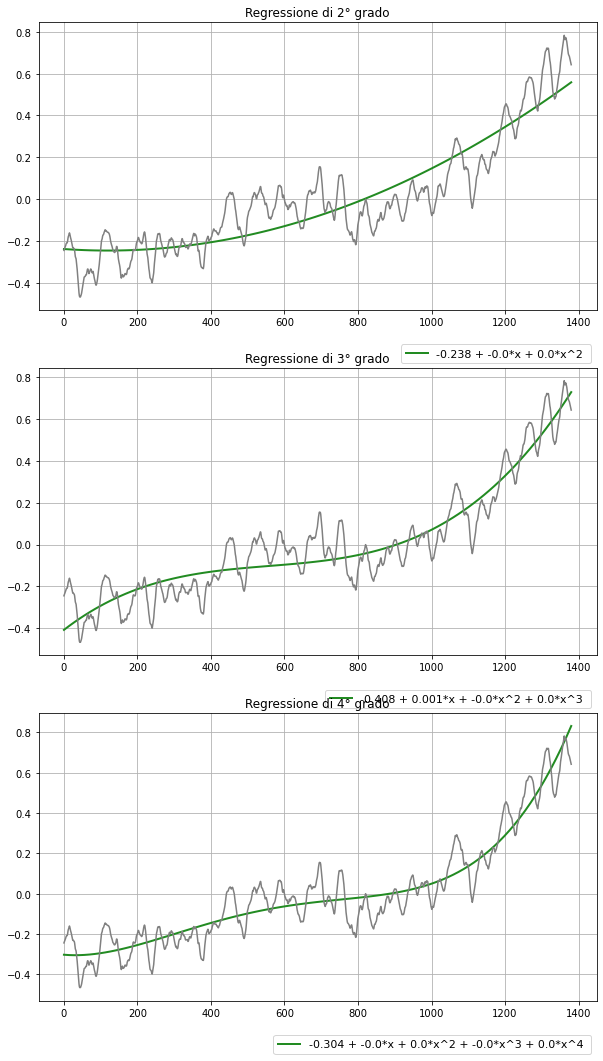

In [224]:
plt.subplots(3,1, figsize = (10,18))
for z,model in enumerate([model_2,model_3,model_4]):
    plt.subplot(3,1,z+1)
    plot_regression(model, time_line, trend, z+2)
    plt.title(f"Regressione di {z+2}° grado")

In [225]:
print(f"r^2 of model_2 is: {round(model_2.rsquared,4)}")
print(f"r^2 of model_3 is: {round(model_3.rsquared,4)}")
print(f"r^2 of model_4 is: {round(model_4.rsquared,4)}")

r^2 of model_2 is: 0.8232
r^2 of model_3 is: 0.8819
r^2 of model_4 is: 0.8992
